<a href="https://colab.research.google.com/github/RicksonMonteiroENCAUT/ChurnPrediction/blob/main/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 2.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

O churn é uma métrica que indica o quanto sua empresa perdeu de receita ou clientes. Os motivos da perda são diversos, desde um produto que não atendeu as expectativas de um cliente a crises financeiras no mercado, serviço ruim, entre outros fatores que podem levar ao cancelamento de um serviço.
O Custo de aquisição de um novo cliente (CAC) pode chegar a ser 15 vezes maior que o para manter um cliente atual.

<p align=center>
<img src="https://raw.githubusercontent.com/RicksonMonteiroENCAUT/ChurnPrediction/master/ChurnIMAGE.jpg" width="50%"></p>


O Custo de aquisição de um novo cliente (CAC) pode chegar a ser 15 vezes maior que o para manter um cliente atual. 

Ao colocar o conceito de churn prediction em prática, é possível identificar quando há a possibilidade de certo cliente abandonar o serviço, criando ações e campanhas específicas afim de evitar esse perda.




## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento superficial sobre o problema.

In [86]:
!pip install imbalanced-learn -q

In [87]:
#Importação das ferramentas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [88]:
df=pd.read_csv('https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [89]:
print('Total entradas: {}'.format(df.shape[0]))
print('Total variáveis: {}'.format(df.shape[1]))

Total entradas: 7043
Total variáveis: 21


In [90]:
#5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#Análise Explanatória

In [91]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [92]:
df.duplicated().sum()

0

In [93]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Analisando as três saídas anteriores verifica-se que o conjunto possui 7043 entradas e 21 colunas, 20 representando as características e 1 informando a classe (Churn ou não). Não foram identificados dados ausentes nem duplicados.

Não foi possível convertar a coluna TotalCharges para float pois foi identificada uma string vazia " ", ou seja, há valores ausentes no conjunto que não foram identificados anteriormente.


In [94]:
def convert(entrada):
  try:
    return float(entrada)
  except ValueError:
    return np.NaN

In [95]:
df.TotalCharges = df['TotalCharges'].apply(convert)
df.TotalCharges.isnull().sum()

11

In [96]:
df['TotalCharges'].fillna(df.TotalCharges.median(), axis=0, inplace=True)

Substituição dos valores nulos pela mediana do conjunto.

In [97]:
df.drop(['customerID'], axis=1, inplace=True)

In [98]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [99]:
df['TotalCharges']=pd.to_numeric(df.TotalCharges)

In [100]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [101]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


A variável `tenure` representa o tempo em que o cliente permanece com o produto (tempo de assinante), apesar de não haver nenhuma documentação achei plausível considera-la em "mes"

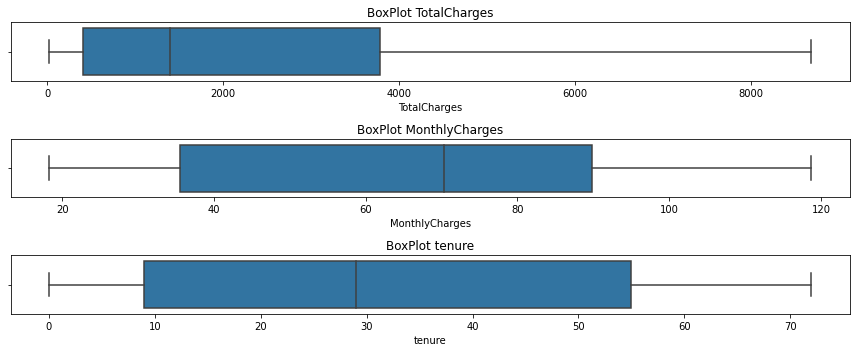

In [102]:
fig, axes = plt.subplots(3, 1, figsize=(12,5))

sns.boxplot(x=df['TotalCharges'], ax=axes[0]).set_title('BoxPlot TotalCharges')
sns.boxplot(x=df['MonthlyCharges'], ax=axes[1]).set_title('BoxPlot MonthlyCharges')
sns.boxplot(x=df['tenure'], ax=axes[2]).set_title('BoxPlot tenure')

plt.tight_layout();

Não foram identificados outliers

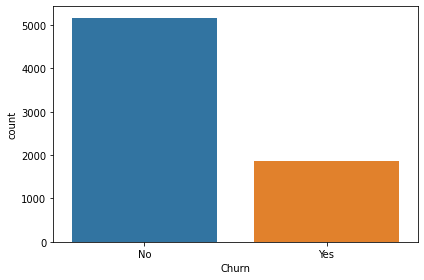

In [103]:
sns.countplot(x=df.Churn)

plt.tight_layout()

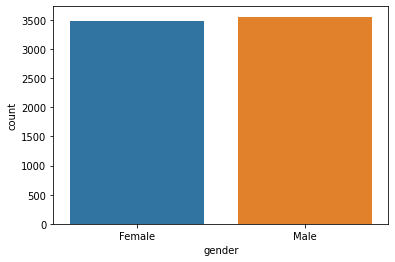

In [104]:
sns.countplot(x=df.gender)

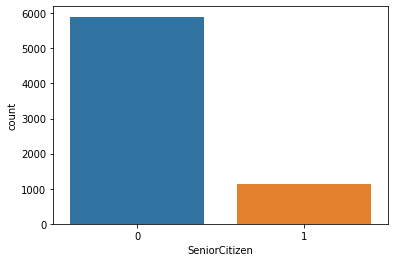

In [105]:
sns.countplot(x=df.SeniorCitizen);

In [106]:
df.SeniorCitizen.value_counts()/df.shape[0]

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

In [107]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

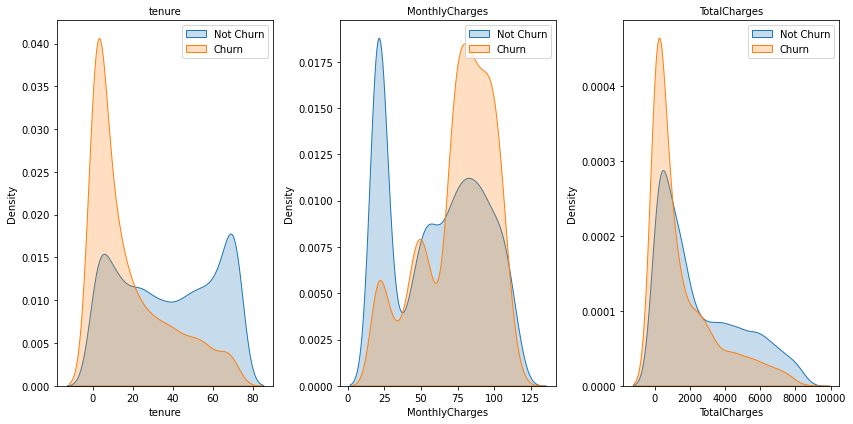

In [108]:
df_0=df.loc[df.Churn=='No']
df_1=df.loc[df.Churn=='Yes']

fig, axes =plt.subplots(1,3,figsize=(12,6))
fig.subplots_adjust(hspace=1, wspace=1)

idx=0

for col in ['tenure',	'MonthlyCharges',	'TotalCharges']:
  idx += 1
  plt.subplot(1, 3, idx)
  sns.kdeplot(df_0[col], label='Not Churn', shade=True)
  sns.kdeplot(df_1[col], label='Churn', shade=True)
  plt.title(col, fontsize=10)
  plt.legend()
plt.tight_layout()

Pelas ditribuições acima pode-se suspeitar alguns pontos, como: 

A maioria dos casos de churn ocorrem entre clientes que possuem menos de 20 meses de assinatura/contrato. Ou seja, após um período 20 meses de "assinatura" há uma menor probabilidade do cliente se tornar um "churn".

Os clientes classificados como churn tendem a realizar uma maior quantidade de "recargas mensais".

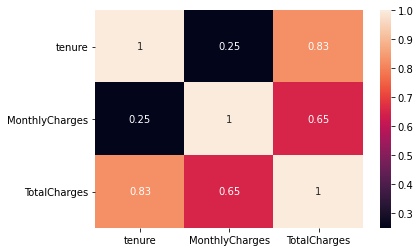

In [109]:
sns.heatmap(df[['tenure',	'MonthlyCharges',	'TotalCharges', 'Churn']].corr(), annot=True)

Como era de se esperar há uma correlação forte entre o `TotalCharges` e a variável `tenure`. O que faz total sentido, compreendendo que quanto maior o tempo um cliente permance como assinante de um serviço, mais recargas ele realiza. Também é possível visualizar uma correlação  moderada entre as variáveis `MonthlyCharges` e `TotalCharges`. 

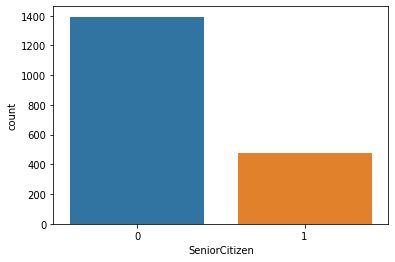

In [110]:
sns.countplot(x=df_1.SeniorCitizen)

In [111]:
df_1.SeniorCitizen.value_counts()/df_1.shape[0]

0    0.745318
1    0.254682
Name: SeniorCitizen, dtype: float64

74,53% dos clientes classificados como `churn` não são idosos.

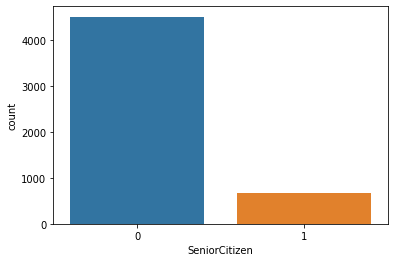

In [112]:
sns.countplot(x=df_0.SeniorCitizen)

#Pré-processamento

In [113]:
#Label encoding para features com 2 classes

columns= df.columns
df_clean=df.copy()
le=LabelEncoder()
for col in columns:
  if len(df[col].value_counts())==2:
    df_clean[col]=le.fit_transform(df[col])
  else: 
    if 'No internet service' in df[col].value_counts():
      df_clean[col].replace('No internet service', 'No', inplace=True)
      df_clean[col]=le.fit_transform(df_clean[col])
    elif 'No phone service' in df[col].value_counts():
      df_clean[col].replace('No phone service', 'No', inplace=True)
      df_clean[col]=le.fit_transform(df_clean[col])

In [114]:
df.OnlineSecurity.value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

In [115]:
df_clean.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [116]:
df.InternetService.value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [117]:
df.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [118]:
df.PaymentMethod.value_counts()	

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [119]:
df_clean

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,DSL,1,0,1,1,1,1,One year,1,Mailed check,84.80,1990.50,0
7039,0,0,1,1,72,1,1,Fiber optic,0,1,1,0,1,1,One year,1,Credit card (automatic),103.20,7362.90,0
7040,0,0,1,1,11,0,0,DSL,1,0,0,0,0,0,Month-to-month,1,Electronic check,29.60,346.45,0
7041,1,1,1,0,4,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Mailed check,74.40,306.60,1


In [120]:
#Encoding para features com mais de duas classes
df_clean = pd.get_dummies(df_clean, columns=['Contract', 'PaymentMethod', 'InternetService' ])

In [121]:
df_clean.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,0,0,1,0,1,0,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,1,0,0,0,0,1,1,0,0
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,0,0,0,1,1,0,0
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,1,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,0,1,0,0,1,0


In [122]:
df_clean.shape

(7043, 27)

Como os dados estavam em forma textual, foi necessário aplicar técnicas de enconding afim de transormar os dados textuais em numéricos afim de obter melhores resultados no treinamento dos modelos.

Com os dados codificados podemos passar para fase de machine learning

#Machine Learning

In [123]:
#Separação dos dados em feature Matriz e target vector
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

0    0.728323
1    0.271677
Name: Churn, dtype: float64


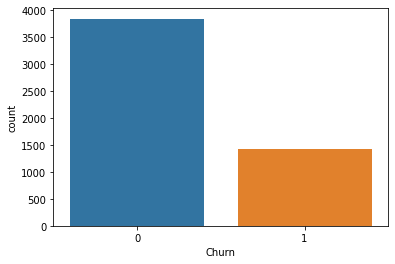

In [125]:
sns.countplot(x=y_train);
print(y_train.value_counts()/y_train.shape[0])

Visualizando o o gráfico de colunas e olhando as porcentagens de cada classe em relação ao dataset completo, é possível perceber o grande desbalanceamento nas classes. 73,46% dos valores correspondem a não churns e apenas 26,54% representas os casos de churn. Esse desbalanceamento no conjunto influencia diretamente no treinamento de um modelo de machine learning, por isso a grande balancear as classes. Nesse projeto escolhi utilizar a técnica RandomUnderSampler disponibilizada pela lib imblearn.

In [126]:
X_train_rus, y_train_rus= RandomUnderSampler().fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


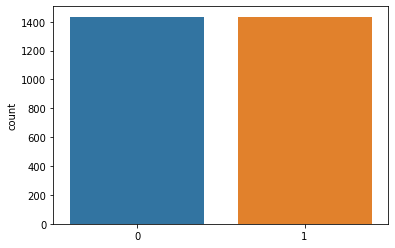

In [127]:
sns.countplot(x=y_train_rus);

A técnica `RandomUnderSampling` elimina aleatoriamente valores da classe predominantes no problema, afim de obter um conjunto mais balanceado. 
É possivel perceber através do gráfico acima como os conjunto está balanceado (Ambos com 1400 entradas). O problema desta técnica é a grande quantidade de dados que é descartada. 

In [128]:
#Padronizando dados
X_train = StandardScaler().fit_transform(X_train_rus)

Com os dados de treino padronizados e balanceados partiremos para criação do modelo.

Testarei os seguintes modelos:

*   Regressão Logística
*   SVC
*   XGboost
*   RandomForest
*   LightGBM




In [129]:
#Instanciando modelos
rl = LogisticRegression()
svc = SVC()
xgb = XGBClassifier()
rf = RandomForestClassifier()
lbm = LGBMClassifier() 

In [130]:
rl.__class__.__name__

'LogisticRegression'

In [131]:
model = []
recall = []

for clf in [rl, svc, xgb, rf, lbm]:
  model.append(clf.__class__.__name__)
  recall.append(cross_val_score(clf, X=X_train_rus, y= y_train_rus, cv=5, scoring='recall').mean())

df_ml= pd.DataFrame(recall, model, columns=['recall'])
df_ml

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,recall
LogisticRegression,0.797909
SVC,0.540070
XGBClassifier,0.809059
RandomForestClassifier,0.772125
LGBMClassifier,0.782578


Nessa primeira etapa realizamos um processo de validação dos modelos afim de encontrar o classificador que melhor se encaixa no problema. O classificador XGboost obteve melhores resultados em relação a métrica de recall, logo escolheremos ele para realizarmos um tuning de hyperparametros.

#Tuning do Classificador XGBoost

Encontrando o melhor número de estimadores

In [132]:
clf = XGBClassifier(learning_rate=0.1,)

param_grid= {
    'n_estimators' : range(0,1000,10)
}
grid= GridSearchCV(clf, param_grid=param_grid, scoring='recall', cv=5)
grid_resul=grid.fit(X_train_rus, y_train_rus)


In [133]:
print('Recall: {}'.format(grid_resul.best_score_ ))
print('best_params: {}'.format(grid_resul.best_params_))

Recall: 0.8118466898954703
best_params: {'n_estimators': 40}


In [145]:
clf= XGBClassifier(learning_rate=0.1, n_estimators= 40 )
param_grid={
    'max_depth': range(3,11)
    }
grid =GridSearchCV(clf, param_grid, scoring='recall', cv=5)

grid_resul= grid.fit(X_train_rus, y_train_rus)

print('Recall: {}'.format(grid_resul.best_score_ ))
print('best_params: {}'.format(grid_resul.best_params_))

Recall: 0.8118466898954703
best_params: {'max_depth': 3}


In [146]:
clf= XGBClassifier(learning_rate=0.1, n_estimators= 40, max_depth=3 )
param_grid={
    'subsample': [i/10 for i in range(5, 11)]
    }
grid =GridSearchCV(clf, param_grid, scoring='recall', cv=5)

grid_resul= grid.fit(X_train_rus, y_train_rus)

print('Recall: {}'.format(grid_resul.best_score_ ))
print('best_params: {}'.format(grid_resul.best_params_))

Recall: 0.8118466898954703
best_params: {'subsample': 1.0}


In [147]:
clf= XGBClassifier(learning_rate=0.1, n_estimators= 40, max_depth=3, subsample= 1)
param_grid={
    'colsample_bytree': [i/10 for i in range(5, 11)]
    }

grid =GridSearchCV(clf, param_grid, scoring='recall', cv=5)

grid_resul= grid.fit(X_train_rus, y_train_rus)

print('Recall: {}'.format(grid_resul.best_score_ ))
print('best_params: {}'.format(grid_resul.best_params_))

Recall: 0.8118466898954703
best_params: {'colsample_bytree': 1.0}


In [148]:
clf= XGBClassifier(learning_rate=0.1, n_estimators= 40, max_depth=3, subsample= 1, colsample_bytree=1)
param_grid={
       'min_child_weight': range(1,5)
    }
    
grid =GridSearchCV(clf, param_grid, scoring='recall', cv=5)

grid_resul= grid.fit(X_train_rus, y_train_rus)

print('Recall: {}'.format(grid_resul.best_score_ ))
print('best_params: {}'.format(grid_resul.best_params_))

Recall: 0.8118466898954703
best_params: {'min_child_weight': 1}


In [151]:
clf = XGBClassifier(learning_rate=0.1, n_estimators= 40, max_depth=3, subsample= 1, colsample_bytree=1, min_child_weight=1)
param_grid= {
    'gamma': [i/10 for i in range(0,10)]
}
grid =GridSearchCV(clf, param_grid, scoring='recall', cv=5)

grid_resul= grid.fit(X_train_rus, y_train_rus)

print('Recall: {}'.format(grid_resul.best_score_ ))
print('best_params: {}'.format(grid_resul.best_params_))

Recall: 0.8125435540069686
best_params: {'gamma': 0.1}


In [153]:
clf = XGBClassifier(learning_rate=0.1, n_estimators= 40, max_depth=3, subsample= 1, colsample_bytree=1, min_child_weight=1, gamma=0.1)
param_grid= {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]
}
grid =GridSearchCV(clf, param_grid, scoring='recall', cv=5)

grid_resul= grid.fit(X_train_rus, y_train_rus)

print('Precision: {}'.format(grid_resul.best_score_ ))
print('best_params: {}'.format(grid_resul.best_params_))

Precision: 0.8125435540069686
best_params: {'learning_rate': 0.1}


In [154]:
clf = XGBClassifier(learning_rate=0.1, n_estimators= 40, max_depth=3, subsample= 1, colsample_bytree=1, min_child_weight=1, gamma=0.1)
param_grid= {
    'scale_pos_weight': [i/10 for i in range(0,100,5)]
}
grid =GridSearchCV(clf, param_grid, scoring='recall', cv=5)

grid_resul= grid.fit(X_train_rus, y_train_rus)

print('Recall: {}'.format(grid_resul.best_score_ ))
print('best_params: {}'.format(grid_resul.best_params_))

Recall: 0.9832752613240417
best_params: {'scale_pos_weight': 9.5}


In [155]:
clf = XGBClassifier(learning_rate=0.1, n_estimators= 40, max_depth=3, subsample= 1, colsample_bytree=1, min_child_weight=1, gamma=0.1, scale_pos_weight=9.5)

model.fit(X_train_rus, y_train_rus)

X_test1 = StandardScaler().fit(X_train).transform(X_test)

In [156]:
y_pred=model.predict(X_test1)

In [157]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.98      0.41      0.58      1327
           1       0.35      0.97      0.52       434

    accuracy                           0.55      1761
   macro avg       0.66      0.69      0.55      1761
weighted avg       0.82      0.55      0.57      1761



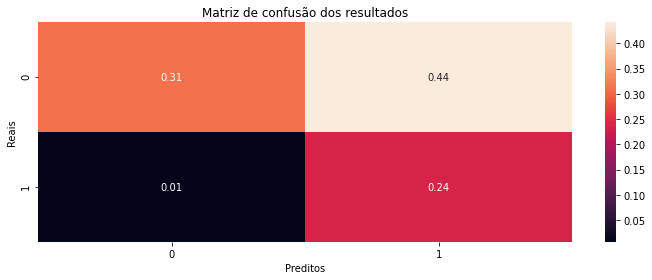

In [158]:
plt.subplots(figsize=(10,4))
sns.heatmap(confusion_matrix(y_test, y_pred)/len(y_pred), annot=True, fmt='.2f');
plt.title('Matriz de confusão dos resultados')
plt.xlabel('Preditos')
plt.ylabel('Reais')
plt.tight_layout()

In [160]:
from sklearn.metrics import roc_auc_score

In [161]:
roc_auc_score(y_test,y_pred)

0.6922574046999747

#Conclusão
Na resolução deste problema foi possível identificar alguns padrões através dos gráficos de distribuição das variáveis numéricas. Que conciliado as predições do modelo pode ser facilmente usado como soluções para minimizar o churn rate de uma empresa.